# Goal: Gridding up stars for MATCH w/ quadtree. Write out to phot filefor MATCH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import geopandas
from shapely.geometry import box, Point
import random
import os 
import folium
import csv
import matplotlib as mpl
import matplotlib.colors as colors

In [2]:
#read in HST catalog and make array of points to grid up
catalog = pd.read_csv('/Users/debbytran/NGC6946/NGC6946_Catalog-Foreground+Blend.csv')
df = catalog[(catalog.color_cut_foreground==0) & (catalog.QF1==1)]
points = np.array([df.RA,df.dec])

In [3]:
def geo(nbins):
    #creating geopandas and plotting dataframe based off of number of bins given 
    h,xedges,yedges,im = plt.hist2d(df.RA,df.dec,nbins)
    poly = np.array([])
    h_poly = np.array([])
    for i in np.arange(nbins):
        for j in np.arange(nbins):
            temp_poly = box(minx=xedges[i],miny=yedges[j],maxx=xedges[i+1],maxy=yedges[j+1])
            poly = np.append(poly,temp_poly)
            h_poly = np.append(h_poly,h[i,j])
    d = {'N_stars':h_poly,'geometry':poly}
    gdf = geopandas.GeoDataFrame(d)
    gdf.plot('N_stars', edgecolor="black",legend=True,aspect=2)
    
    return gdf

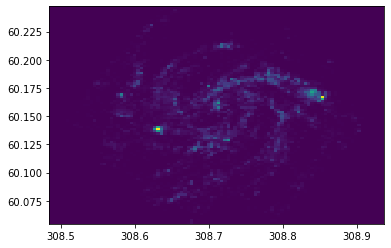

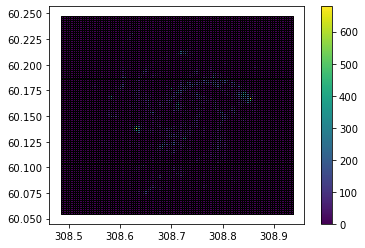

In [4]:
gdf = geo(100)

In [19]:
#most recent working version
class Point:
    """A point located at (x,y) in 2D space.

    Each Point object may be associated with a payload object.

    """

    def __init__(self, x, y, payload=None):
        self.x, self.y = x, y
        self.payload = payload

    def __repr__(self):
        return '{}: {}'.format(str((self.x, self.y)), repr(self.payload))
    def __str__(self):
        return 'P({:.2f}, {:.2f})'.format(self.x, self.y)

    def distance_to(self, other):
        try:
            other_x, other_y = other.x, other.y
        except AttributeError:
            other_x, other_y = other
        return np.hypot(self.x - other_x, self.y - other_y)

class Rect:
    """A rectangle centered at (cx, cy) with width w and height h."""

    def __init__(self, cx, cy, w, h):
        self.cx, self.cy = cx, cy
        self.w, self.h = w, h
        self.west_edge, self.east_edge = cx - w/2, cx + w/2
        self.north_edge, self.south_edge = cy - h/2, cy + h/2

    def __repr__(self):
        return str((self.west_edge, self.east_edge, self.north_edge,
                self.south_edge))

    def __str__(self):
        return '({:.8f}, {:.8f}, {:.8f}, {:.8f})'.format(self.west_edge,
                    self.north_edge, self.east_edge, self.south_edge)

    def contains(self, point):
        """Is point (a Point object or (x,y) tuple) inside this Rect?"""

        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point

        return (point_x >= self.west_edge and
                point_x <  self.east_edge and
                point_y >= self.north_edge and
                point_y < self.south_edge)
    

    def intersects(self, other):
        """Does Rect object other interesect this Rect?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def draw(self, ax, c='k', lw=0.5, **kwargs):
        x1, y1 = self.west_edge, self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        ax.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c=c, lw=lw, **kwargs)
    


class QuadTree:
    """A class implementing a quadtree."""

    def __init__(self, boundary, max_points=50, min_size=0.0001, depth=0):
        """Initialize this node of the quadtree.

        boundary is a Rect object defining the region from which points are
        placed into this node; max_points is the maximum number of points the
        node can hold before it must divide (branch into four more nodes); 
        min_size is the smallest size a node can be
        depth keeps track of how deep into the quadtree this node lies.

        """

        self.boundary = boundary
        self.max_points = max_points
        self.min_size = min_size
        self.points = []
        self.depth = depth
        # A flag to indicate whether this node has divided (branched) or not.
        self.divided = False

    def __str__(self):
        """Return a string representation of this node, suitably formatted."""
        sp = ' ' * self.depth * 2
        s = str(self.boundary) + '\n' 
        s += sp + ', '.join(str(point) for point in self.points)
        if not self.divided:
            return s
        return s + '\n' + '\n'.join([
                sp + 'nw: ' + str(self.nw), sp + 'ne: ' + str(self.ne),
                sp + 'se: ' + str(self.se), sp + 'sw: ' + str(self.sw)])

    
    def divide(self):
        """Divide (branch) this node by spawning four children nodes."""

        cx, cy = self.boundary.cx, self.boundary.cy
        w, h = self.boundary.w / 2, self.boundary.h / 2
        # The boundaries of the four children nodes are "northwest",
        # "northeast", "southeast" and "southwest" quadrants within the
        # boundary of the current node.
        self.nw = QuadTree(Rect(cx - w/2, cy - h/2, w, h),
                                    self.max_points, self.min_size, self.depth + 1)
        self.ne = QuadTree(Rect(cx + w/2, cy - h/2, w, h),
                                    self.max_points, self.min_size, self.depth + 1)
        self.se = QuadTree(Rect(cx + w/2, cy + h/2, w, h),
                                    self.max_points, self.min_size, self.depth + 1)
        self.sw = QuadTree(Rect(cx - w/2, cy + h/2, w, h),
                                    self.max_points, self.min_size, self.depth + 1)
        self.divided = True

    def insert(self, point):
        """Try to insert Point point into this QuadTree."""

        if not self.boundary.contains(point):
            # The point does not lie inside boundary: bail.
            return False
        
        if self.min_size>self.boundary.w and self.min_size>self.boundary.h:
            #if the size of the grid is smaller than the min_size, bail
            return False

        if len(self.points) < self.max_points:
            # There's room for our point without dividing the QuadTree.
            self.points.append(point)
            return True

        # No room: divide if necessary and grid is bigger than min size, then try the sub-quads.
        if not self.divided:
            self.divide()

        return (self.ne.insert(point) or
                self.nw.insert(point) or
                self.se.insert(point) or
                self.sw.insert(point))

    def __len__(self):
        """Return the number of points in the quadtree."""

        npoints = len(self.points)
        if self.divided:
            npoints += len(self.nw)+len(self.ne)+len(self.se)+len(self.sw)
        return npoints

    def draw(self, ax):
        """Draw a representation of the quadtree on Matplotlib Axes ax."""

        self.boundary.draw(ax)
        if self.divided:
            self.nw.draw(ax)
            self.ne.draw(ax)
            self.se.draw(ax)
            self.sw.draw(ax)

In [20]:
#inspired by: https://loomsci.wordpress.com/2013/06/20/recursive-subdivision-circles/
#adapted from: https://scipython.com/blog/quadtrees-2-implementation-in-python/
DPI = 72
width, height = (np.max(df.RA)-np.min(df.RA))/np.cos(np.mean(df.dec)*np.pi/180),(np.max(df.RA)-np.min(df.RA))
ra_center, dec_center = (np.max(df.RA)+np.min(df.RA))/2, (np.max(df.dec)+np.min(df.dec))/2
coords = np.transpose(np.array([df.RA,df.dec]))
points = [Point(*coord) for coord in coords]

domain = Rect(ra_center, dec_center, width, height)
qtree = QuadTree(domain, 50, min_size=0.003)
for point in points:
    qtree.insert(point)

print('Number of points in the domain =', len(qtree))


xmax = ra_center + width/2
ymax = dec_center + height/2
xmin = ra_center - width/2
ymin = dec_center - height/2

Number of points in the domain = 72559


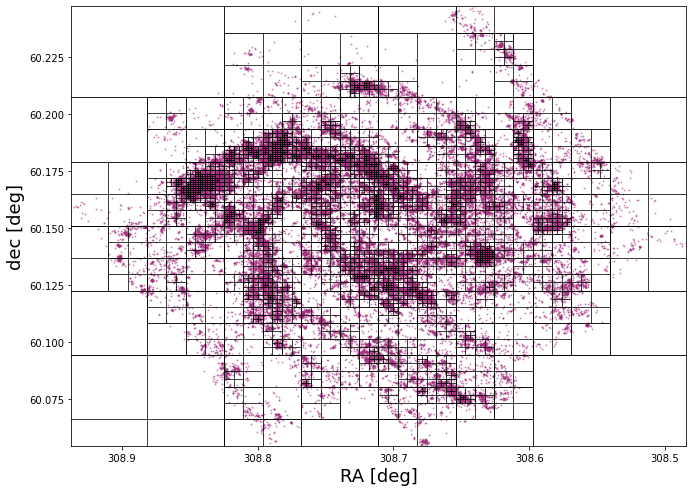

In [21]:
cmap = mpl.cm.get_cmap("magma").copy()
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(min(df.RA), max(df.RA))
ax.set_ylim(min(df.dec),max(df.dec))
# ax.set_title('NGC 6946 Grids')
ax.set_xlabel('RA [deg]',fontsize=18)
ax.set_ylabel('dec [deg]',fontsize=18)
qtree.draw(ax)

ax.scatter([p.x for p in points], [p.y for p in points], s=1,color=cmap(0.45),alpha=0.4)
#ax.set_xticks([xmin,min(df.RA),max(df.RA),xmax])
#ax.set_yticks([ymin,min(df.dec),max(df.dec),ymax])

ax.invert_xaxis()
plt.tight_layout()
plt.savefig('search-quadtree',format='pdf')
plt.show()

In [22]:
##### extract coordinates of the vertices of the grids from the string
vertices_string = qtree.__str__()
string_arr =vertices_string.split(sep=':')

for i in np.arange(len(string_arr)):
    split_string= string_arr[i].split(')\n',1)
    string_arr[i] = split_string[0]
    
for i in np.arange(len(string_arr)):
    if i == 0:
        split_string = string_arr[i].split('(',1)
        string_arr[i] = split_string[1]
    if i != 0: 
        split_string = string_arr[i].split(' (',1)
        string_arr[i] = split_string[1]
        
vertices = np.array([])
for i in np.arange(len(string_arr)):
    vertices = np.append(vertices,np.fromstring(string_arr[i], sep=', '))

# west, north, east, south     
vertices = np.reshape(vertices,(-1,4))
vertices = pd.DataFrame({'xmin':vertices[:,0],'ymin':vertices[:,1],'xmax':vertices[:,2],'ymax':vertices[:,3]})

In [23]:
def check_subgrid(arr1,arr2):
#check if grid1 (set by vertices in arr1) is inside grid2 (set by vertices in arr2) and vice versa
#returns the vertices of the subgrid
    xmin1, ymin1, xmax1, ymax1 = arr1
    xmin2, ymin2, xmax2, ymax2 = arr2
    if (xmin1==xmin2) and (ymin1==ymin2): 
        if (xmax1<xmax2) and (ymax1<ymax2):
            return xmin1,ymin1,xmax1,ymax1
        if (xmax1>xmax2) and (ymax1>ymax2):
            return xmin2,ymin2,xmax2,ymax2
    
    if (xmax1==xmax2) and (ymax1==ymax2):
        if (xmin1>xmin2) and (ymin1>ymin2):
            return xmin1,ymin1,xmax1,ymax1
        if (xmin1<xmin2) and (ymin1<ymin2):
            return xmin2,ymin2,xmax2,ymax2
        
    if (xmin1==xmin2) and (ymax1==ymax2):
        if (xmax1<xmax2) and (ymin1>ymin2):
            return xmin1,ymin1,xmax1,ymax1
        if (xmax1>xmax2) and (ymin1<ymin2):
            return xmin2,ymin2,xmax2,ymax2
        
    if (xmax1==xmax2) and (ymin1==ymin2):
        if (xmin1>xmin2) and (ymax1<ymax2):
            return xmin1,ymin1,xmax1,ymax1
        if (xmin1<xmin2) and (ymax1>ymax2):
            return xmin2,ymin2,xmax2,ymax2

#create duplicate - essentially setting the larger grids to be equal to the subgrid and removing duplicates later
def no_repeat(vertices):
    vertices_copy = vertices.copy()
    x_unique = np.unique(np.append(vertices.xmin.unique(),vertices.xmax.unique()))
    y_unique = np.unique(np.append(vertices.ymin.unique(),vertices.ymax.unique()))
    #go through all possible combos of vertices to check against whether they are subgrids
    for i in x_unique:
        for j in y_unique:
            index = vertices[(vertices.xmin==i)&(vertices.ymin==j)].index
            for k in index:
                for l in index:
                    if k!=l: 
                        sub = check_subgrid(vertices.iloc[k].values,vertices.iloc[l].values)
                        vertices_copy.loc[k,['xmin','ymin','xmax','ymax']] = sub
                        vertices_copy.loc[l,['xmin','ymin','xmax','ymax']] = sub
            index = vertices[(vertices.xmin==i)&(vertices.ymax==j)].index
            for k in index:
                for l in index:
                    if k!=l: 
                        sub = check_subgrid(vertices.iloc[k].values,vertices.iloc[l].values)
                        vertices_copy.loc[k,['xmin','ymin','xmax','ymax']] = sub
                        vertices_copy.loc[l,['xmin','ymin','xmax','ymax']] = sub
            index = vertices[(vertices.xmax==i)&(vertices.ymax==j)].index
            for k in index:
                for l in index:
                    if k!=l: 
                        sub = check_subgrid(vertices.iloc[k].values,vertices.iloc[l].values)
                        vertices_copy.loc[k,['xmin','ymin','xmax','ymax']] = sub
                        vertices_copy.loc[l,['xmin','ymin','xmax','ymax']] = sub
            index = vertices[(vertices.xmax==i)&(vertices.ymin==j)].index
            for k in index:
                for l in index:
                    if k!=l: 
                        sub = check_subgrid(vertices.iloc[k].values,vertices.iloc[l].values)
                        vertices_copy.loc[k,['xmin','ymin','xmax','ymax']] = sub
                        vertices_copy.loc[l,['xmin','ymin','xmax','ymax']] = sub
    new_array = [tuple(row) for row in vertices_copy.values]
    uniques = np.unique(new_array,axis=0)
    xmin_unique,ymin_unique,xmax_unique,ymax_unique=np.transpose(uniques)
    #vertices (only leaves of the quadtree)
    vertices_norepeat = pd.DataFrame({'xmin':xmin_unique,'ymin':ymin_unique,'xmax':xmax_unique,'ymax':ymax_unique})
    return vertices_norepeat
        
def check_in_grid(coords,xmin,xmax,ymin,ymax):
#given an array of xy coords, count the number of stars 
#that lie within a box bound by xmin,xmax,ymin,ymax
    count = 0
    x,y = np.transpose(coords)
    for i in np.arange(len(coords)):
        if (x[i]>xmin) and (y[i]>ymin) and (x[i]<xmax) and (y[i]<ymax):
            count = count + 1
    return count 

def check_in_grid_idx(coords,xmin,xmax,ymin,ymax):
#given an array of xy coords, count the number of stars 
#that lie within a box bound by xmin,xmax,ymin,ymax
    x,y = np.transpose(coords)
    arr = np.array([])
    for i in np.arange(len(coords)):
        if (x[i]>xmin) and (y[i]>ymin) and (x[i]<xmax) and (y[i]<ymax):
            arr = np.append(arr,i)
    return arr

In [24]:
vertices_norepeat = no_repeat(vertices)

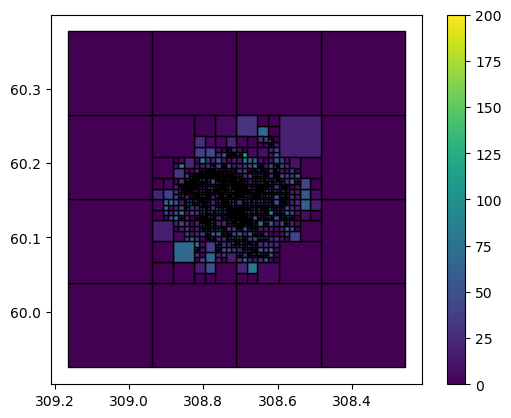

In [25]:
#creating N_stars and small geopandas dataframe of grids
temp_hist = np.array([])
for i in np.arange(len(vertices_norepeat)):
    temp_hist = np.append(temp_hist,
                          check_in_grid(np.transpose(np.array([df.RA,df.dec])),vertices_norepeat.xmin[i]
                                        ,vertices_norepeat.xmax[i],
                                        vertices_norepeat.ymin[i],vertices_norepeat.ymax[i]))
    
poly = np.array([])
for i in np.arange(len(vertices_norepeat)):
    temp_poly = box(minx=vertices_norepeat.xmin[i],miny=vertices_norepeat.ymin[i],
                    maxx=vertices_norepeat.xmax[i],maxy=vertices_norepeat.ymax[i])
    poly = np.append(poly,temp_poly)
d = {'N_stars':temp_hist,'xmin':vertices_norepeat.xmin.values,'xmax':vertices_norepeat.xmax.values,
     'ymin':vertices_norepeat.ymin.values,'ymax':vertices_norepeat.ymax.values,
     'width':vertices_norepeat.xmax.values-vertices_norepeat.xmin.values,
     'height':vertices_norepeat.ymax.values-vertices_norepeat.ymin.values,'geometry':poly}
gdf_test = geopandas.GeoDataFrame(d)
gdf_test.plot('N_stars', edgecolor="black",legend=True,aspect=2)
plt.gca().invert_xaxis()

size = gdf_test.width.values*gdf_test.height.values*np.cos(
    (np.mean(np.array([gdf_test.ymin.values,gdf_test.ymax.values])))*np.pi/180)*3600**2
gdf_test['grid_size'] = size

#getting all stars above 25 mag in F336W to stellar densities 
df_high_mag = df[df.mag336<25]
temp_hist1 = np.array([])
for i in np.arange(len(vertices_norepeat)):
    temp_hist1 = np.append(temp_hist1,
                          check_in_grid(np.transpose(np.array([df_high_mag.RA,df_high_mag.dec]))
                                        ,vertices_norepeat.xmin[i],vertices_norepeat.xmax[i],
                                        vertices_norepeat.ymin[i],vertices_norepeat.ymax[i]))
density = temp_hist1/gdf_test.grid_size
gdf_test['density']=density

grid_index = np.arange(len(gdf_test))
gdf_test['grid_index'] = grid_index

In [41]:
from shapely.geometry import box, Point
#combining grid dataframe with catalog dataframe
df = df.reset_index(drop=True)
geo_arr = []
for i in np.arange(len(df)):
    geo_arr.append(Point(df.RA.values[i],df.dec.values[i]))
geo_arr = geopandas.GeoSeries(geo_arr)



df_geo = geopandas.GeoDataFrame(df,geometry=geo_arr)

catalog_gridded = df_geo.sjoin(gdf_test,how="right")
catalog_gridded = catalog_gridded[(np.invert(pd.isna(catalog_gridded.index_left.values)))]
catalog_gridded.drop(columns=['index_left'],inplace=True)

KeyError: "['level_0', 'index'] not found in axis"

In [49]:
gdf_test.to_file('/Users/debbytran/NGC6946/grid.shp',index=False)
catalog_gridded.to_file('/Users/debbytran/NGC6946/catalog_gridded.shp',index=False)

/var/folders/5w/06bpkb917f19qqrddl3rkkqm0000gn/T/ipykernel_85085/1125750103.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  catalog_gridded.to_file('/Users/debbytran/NGC6946/catalog_gridded.shp',index=False)


In [66]:
catalog_gridded[(catalog_gridded.blend==1) &(catalog_gridded.grid_index==2578)]

,RA,dec,mag275,uncert275,mag336,uncert336,snr275,snr336,crowding27,crowding33,...,xmin,xmax,ymin,ymax,width,height,grid_size,density,grid_index,geometry
79822,308.855287,60.166005,18.688,0.008,18.762,0.006,128.4,190.7,0.108,0.104,...,308.854769,308.856544,60.165938,60.166821,0.001775,0.000883,10.112987,12.162579,2578,"POLYGON ((308.857 60.166, 308.855 60.166, 308...."
79823,308.855425,60.166557,19.404,0.008,19.201,0.005,129.4,223.3,0.173,0.163,...,308.854769,308.856544,60.165938,60.166821,0.001775,0.000883,10.112987,12.162579,2578,"POLYGON ((308.857 60.166, 308.855 60.166, 308...."
79824,308.854801,60.166268,19.373,0.014,19.502,0.016,78.5,67.2,0.240,0.263,...,308.854769,308.856544,60.165938,60.166821,0.001775,0.000883,10.112987,12.162579,2578,"POLYGON ((308.857 60.166, 308.855 60.166, 308...."


In [57]:
catalog_gridded.columns

Index(['RA', 'dec', 'mag275', 'uncert275', 'mag336', 'uncert336', 'snr275',
       'snr336', 'crowding27', 'crowding33', 'sharpness2', 'sharpness3',
       'chi275', 'chi336', 'roundness2', 'roundness3', 'field', 'x', 'y',
       'QF1', 'color_cut_', 'gaia_match', 'gaia_sourc', 'blend', 'N_stars',
       'xmin', 'xmax', 'ymin', 'ymax', 'width', 'height', 'grid_size',
       'density', 'grid_index', 'geometry'],
      dtype='object')

In [17]:
m = gdf_test.explore("density")

df_geo.explore(m=m, marker_kwds=dict(radius=1, fill=True))

folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

NameError: name 'df_geo' is not defined

In [52]:
#making directories and input files for MATCH from original catalog
catalog_gridded = geopandas.read_file('/Users/debbytran/NGC6946/catalog_gridded.shp')
os.chdir('/Users/debbytran/NGC6946/sfh/MATCH/grids')
for i in catalog_gridded.grid_index.unique():
    temp = catalog_gridded[(catalog_gridded.grid_index==i)].copy()
    temp = temp[np.invert(np.isnan(temp.RA.values))]
    if len(temp)>0:
        if i<10:
            I = '000'+str(i)
        if (i>9) & (i<100):
            I = '00'+str(i)
        if (i>99) & (i<1000):
            I = '0'+str(i)
        if i>999:
            I = str(i)
        path = '/Users/debbytran/NGC6946/sfh/MATCH/grids/NGC6946_'+I
        if not os.path.exists(path):
            os.makedirs(path)
        os.chdir(path)
        temp.to_csv('NGC6946_grid_'+I+'_catalog.csv',index=False)
        temp_mag = temp[['mag275','mag336']].copy()
        temp_mag.to_csv('NGC6946_'+I+'.match', sep=' ',index=False,header=False, float_format='%7.3f',quoting=csv.QUOTE_NONE,escapechar=' ')

        os.chdir('..')